## 预处理

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# %config InlineBackend.figure_format = 'svg'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
%matplotlib notebook
%matplotlib notebook

In [6]:
# nbaData = pd.read_csv('./data/nba/nba.csv')
# nbaData.head()

In [7]:
# lionData = pd.read_csv('./data/lion-reference.csv',header=None)
# lionData.head()

In [8]:
# cactusData = pd.read_csv('./data/Cactus.txt',header=None,sep='\t')
# cactusData.head()

In [9]:
catData = pd.read_csv('./data/cat-reference.csv',header=None)
catData.head()

,0,1,2
0,0.013579,0.215377,-0.170891
1,0.010493,0.226649,-0.173601
2,0.020415,0.230665,-0.175927
3,0.060064,0.241075,-0.140388
4,0.057849,0.251924,-0.140969


寻找一种好的降维方法，正交化？

In [10]:
data = catData

In [11]:
N = len(data)
print("N :",N)

N : 7207


In [12]:
# a = preprocessing.normalize(data.values)
a = data.values

**设定最近邻的参数K**

In [14]:
k = 4

In [15]:
neigh = NearestNeighbors(n_neighbors=k+1) # 因为之后提取最近点时会包括点自身
neigh.fit(a)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [16]:
disMat,nodeMat = neigh.kneighbors(a)

In [17]:
print(disMat.shape)
print(disMat)

(7207, 5)
[[0.         0.01083073 0.01181896 0.01199689 0.01338931]
 [0.         0.01032152 0.01067763 0.01095375 0.01142065]
 [0.         0.0072728  0.00889288 0.01095375 0.01156028]
 ...
 [0.         0.0048267  0.00555392 0.00765566 0.00789152]
 [0.         0.00519887 0.00555392 0.00555816 0.0080563 ]
 [0.         0.00999151 0.01083073 0.01156028 0.01441222]]


In [18]:
print(nodeMat.shape)
print(nodeMat)

(7207, 5)
[[   0 7206   49    1   64]
 [   1   67   64    2   69]
 [   2    8   68    1 7206]
 ...
 [7204 7201 7205 7191 7203]
 [7205 7192 7204 7202 7203]
 [7206    7    0    2    8]]


In [ ]:
a = disMat.flatten()
plt.title('边的权值分布');
plt.hist(a[a.nonzero()],bins=100)

<IPython.core.display.Javascript object>

## 建图

In [20]:
G = nx.Graph()

In [21]:
G.add_nodes_from(range(nodeMat.shape[0]))

In [22]:
edges = []
for i,(neighbors,distances) in enumerate(zip(nodeMat,disMat)):
    edges +=[(i, neighbors[j], distances[j]) for j in range(k+1) if neighbors[j]!=i]
print(edges[:5])

[(0, 7206, 0.010830732800692664), (0, 49, 0.011818959810406333), (0, 1, 0.01199689459818665), (0, 64, 0.013389309840316665), (1, 67, 0.010321521447926208)]


In [23]:
G.add_weighted_edges_from(edges)

In [24]:
print('node size',len(G.nodes))

node size 7207


### 3D

<IPython.core.display.Javascript object>


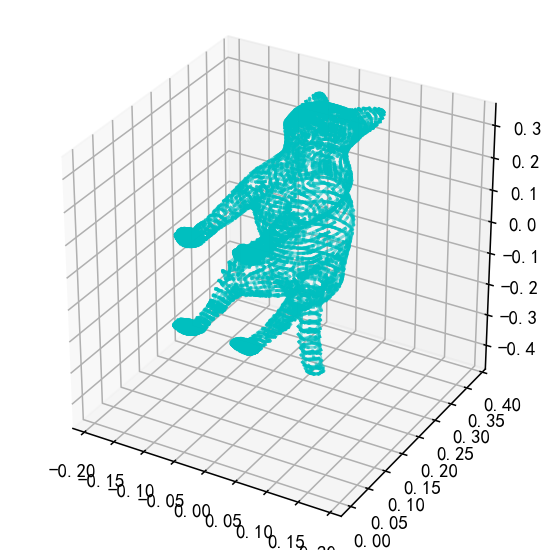

(-0.08029670000000001,
 0.07838270000000001,
 -0.018174350000000002,
 0.40128535000000004)

In [25]:
fig = plt.figure(figsize=(4,4))
ax = Axes3D(fig)
# ax.scatter3D(*data.to_numpy().T,marker='.')
for a,b,_ in edges:
    if np.random.rand()>0.5:
        ax.plot(*data.iloc[[a,b]].to_numpy().T,alpha=0.5,color='c')
ax.axis('equal')

### plain

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


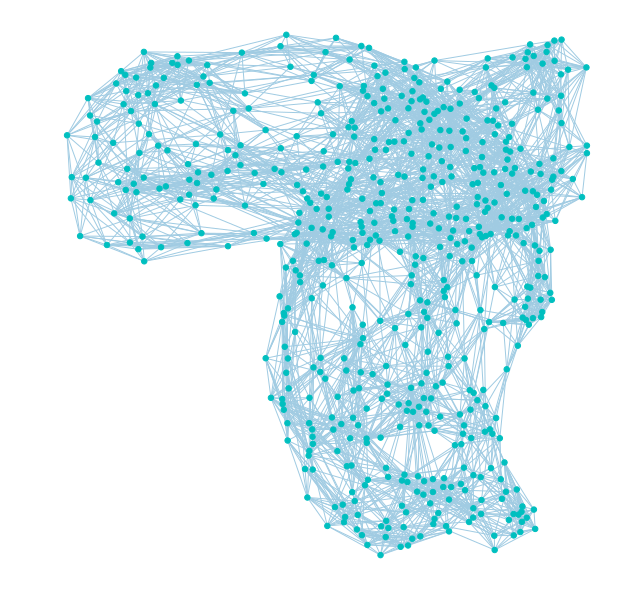

In [19]:
# plt.figure(figsize=(8,8))
# pos = nx.spring_layout(G)
# nx.draw(G,node_shape='o',pos=pos,node_size=30,node_color='c',edge_color='#A0CBE2')

## 投票

https://networkx.github.io/documentation/stable/reference/algorithms/shortest_paths.html

In [26]:
dis = dict(nx.all_pairs_bellman_ford_path_length(G))

In [57]:
with open('disMat','w') as f:
    f.write(str(N)+'\n')
    for i in range(N):
        for j in range(N):
            try:
                d = dis[i][j]
            except KeyError:
                d = -1
            f.write(str(d)+' ')

In [42]:
del dis

仅作为参考，现在使用c实现这一部分
```
nodeIdx = list(range(N))
samples = 50000
subSamples = 10000
th = 0.01
conditon = lambda a,b,c,d:abs(dis[a][b]-dis[c][d])<th and abs(dis[a][d]-dis[b][c])<th

votes = defaultdict(int)

for i in range(samples):
    a,b,c,d=np.random.choice(nodeIdx,4)
    if conditon(a,b,c,d):
        for j in range(subSamples):
            e,f = np.random.choice(nodeIdx,2)
            if conditon(a,b,e,f) and conditon(c,d,e,f):
                if b>a:
                    a,b=b,a
                if d>c:
                    c,d=d,c
                votes[(a,b)]+=1
                votes[(c,d)]+=1
```

In [154]:
a = np.loadtxt('./out.txt')
votes = defaultdict(int)
for i,j in zip(a.nonzero()[0],a.nonzero()[1]):
    v = a[i,j]
    assert v>0
    if i==j:continue
    if i<j:
        i,j=j,i
    votes[(i,j)] += v

In [156]:
votes

defaultdict(int,
            {(2523, 2): 7.0,
             (2155, 4): 10.0,
             (2393, 4): 6.0,
             (2057, 5): 2.0,
             (1006, 7): 7.0,
             (1727, 10): 4.0,
             (966, 11): 2.0,
             (765, 12): 5.0,
             (1678, 13): 20.0,
             (481, 14): 1.0,
             (1532, 18): 24.0,
             (299, 19): 6.0,
             (1034, 19): 15.0,
             (1694, 19): 6.0,
             (2091, 22): 13.0,
             (2254, 22): 3.0,
             (857, 23): 14.0,
             (3056, 23): 1.0,
             (1834, 27): 2.0,
             (3050, 42): 2.0,
             (122, 45): 8.0,
             (3040, 46): 4.0,
             (1884, 50): 9.0,
             (1425, 60): 3.0,
             (3180, 61): 10.0,
             (2176, 65): 7.0,
             (1730, 80): 4.0,
             (1627, 84): 14.0,
             (2336, 85): 5.0,
             (1921, 87): 12.0,
             (2291, 91): 5.0,
             (674, 94): 2.0,
             (921, 102): 1

<IPython.core.display.Javascript object>


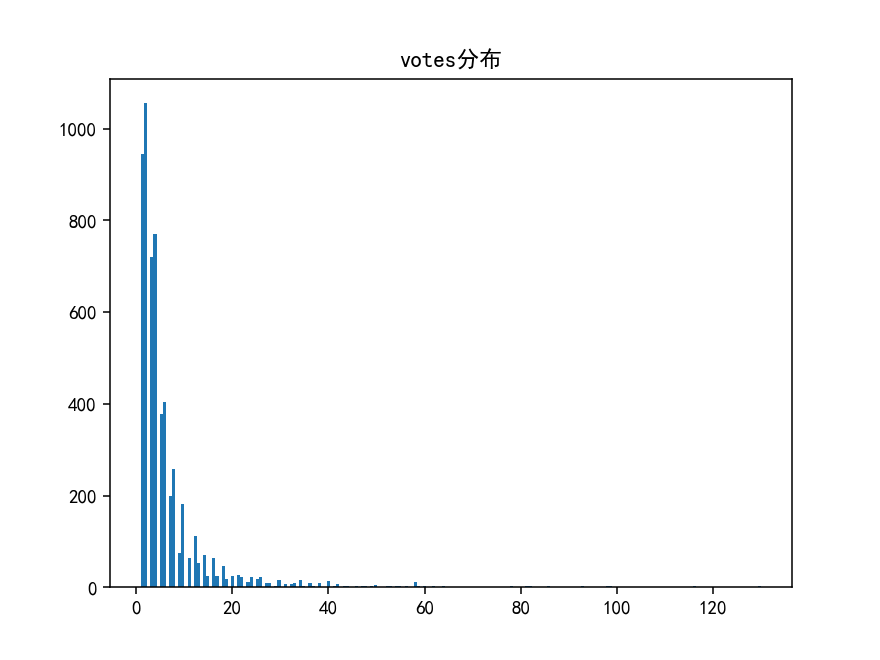

(array([ 945., 1055.,    0.,  721.,  771.,    0.,  378.,  404.,    0.,
         200.,  258.,    0.,   74.,  182.,    0.,   63.,    0.,  113.,
          54.,    0.,   70.,   25.,    0.,   65.,   24.,    0.,   46.,
          18.,    0.,   24.,    0.,   26.,   22.,    0.,   12.,   22.,
           0.,   18.,   22.,    0.,   10.,   10.,    0.,    4.,   16.,
           0.,    8.,    0.,    8.,   10.,    0.,   16.,    4.,    0.,
          10.,    2.,    0.,   10.,    0.,    0.,   14.,    0.,    4.,
           8.,    0.,    2.,    2.,    0.,    0.,    4.,    0.,    2.,
           4.,    0.,    2.,    6.,    0.,    0.,    0.,    4.,    2.,
           0.,    4.,    2.,    0.,    2.,    0.,    0.,   12.,    2.,
           0.,    4.,    0.,    0.,    4.,    0.,    0.,    4.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    4.,    0.,    0.,    0.,    0.,    2.,    2.,
      

In [29]:
# plt.xlim((0,50))
plt.title('votes分布')
plt.hist(votes.values(),bins=200)

In [30]:
path = dict(nx.all_pairs_bellman_ford_path(G))

**设定votes的阈值**

In [52]:
th_votes = 30

In [53]:
nodeSet = set()
for a,b in votes.keys():
    pi = path[a][b]
    if votes[(a,b)]>th_votes:
        nodeSet.add(pi[len(pi)//2])
print('len of nodeSet:',len(nodeSet))
print(nodeSet)

len of nodeSet: 169
{2, 3, 518, 8, 520, 1544, 525, 13, 2063, 1552, 1045, 3095, 1048, 1562, 2586, 2077, 31, 543, 1057, 36, 1574, 1575, 551, 1577, 1077, 568, 570, 572, 1085, 573, 62, 71, 2126, 2128, 1110, 2648, 1116, 3172, 1126, 113, 3185, 632, 1145, 2684, 1661, 1151, 2182, 3207, 1676, 657, 145, 660, 2710, 665, 3226, 3229, 676, 167, 2217, 2218, 3244, 3252, 696, 186, 2746, 698, 190, 2240, 707, 198, 1223, 1225, 1227, 2255, 1233, 1748, 2774, 2263, 2776, 2779, 731, 1760, 1761, 738, 2275, 2794, 235, 747, 247, 1785, 251, 2817, 1795, 2819, 267, 2320, 785, 2834, 787, 1300, 789, 788, 277, 2329, 281, 1824, 801, 803, 1829, 2344, 1834, 1838, 1327, 1328, 2866, 819, 1336, 1849, 314, 1347, 325, 1864, 1357, 2898, 2911, 1380, 1384, 361, 1386, 1388, 2929, 1400, 2425, 1914, 2940, 1923, 1412, 1413, 1929, 1934, 2958, 1422, 1424, 1426, 1429, 2970, 933, 1958, 435, 3006, 2498, 963, 2501, 454, 1992, 457, 1996, 973, 3026, 1502, 1506, 3048, 1003, 1005, 1007, 500, 2037, 3066, 2556}


In [ ]:
# del path

## 构建子图

### 3D

<IPython.core.display.Javascript object>


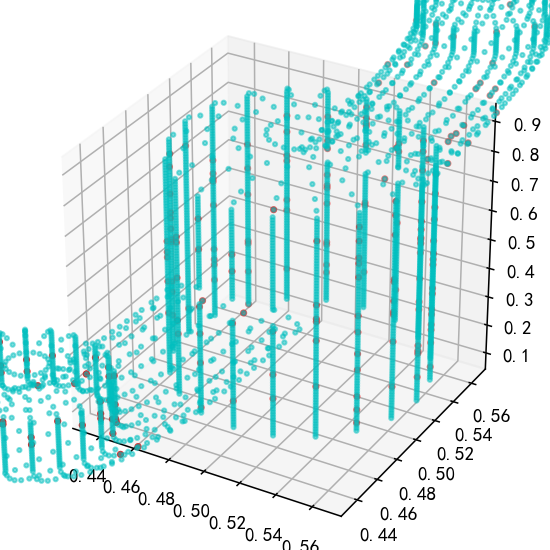

(0.4273395, 0.5726605, 0.2214679, 0.7785321)

In [49]:
fig = plt.figure(figsize=(4,4))
ax = Axes3D(fig)
ax.scatter3D(*data.to_numpy().T,marker='.',color='c',alpha=0.5)
ax.scatter3D(*data.iloc[[*nodeSet]].to_numpy().T,marker='.',s=30,color='r')
ax.axis('equal')

In [50]:
G2 = G.subgraph(nodeSet)
edgeSet = G2.edges() # not set actually

<IPython.core.display.Javascript object>


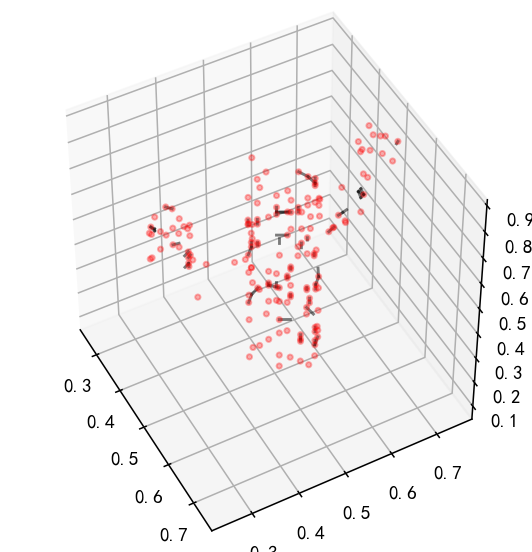

(0.4273395, 0.5726605, 0.22181829999999997, 0.7711737)

In [54]:
fig = plt.figure(figsize=(4,4))
ax = Axes3D(fig)
# ax.scatter3D(*data.to_numpy().T,marker='.',color='c',alpha=0.5)
ax.scatter3D(*data.iloc[[*nodeSet]].to_numpy().T,marker='.',s=30,color='r',alpha=0.3)
for a,b in edgeSet:
    if np.random.rand()>-1:
        ax.plot(*data.iloc[[a,b]].to_numpy().T,alpha=0.5,color='k')
ax.axis('equal')

### plain

**在原图位置上展示**

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


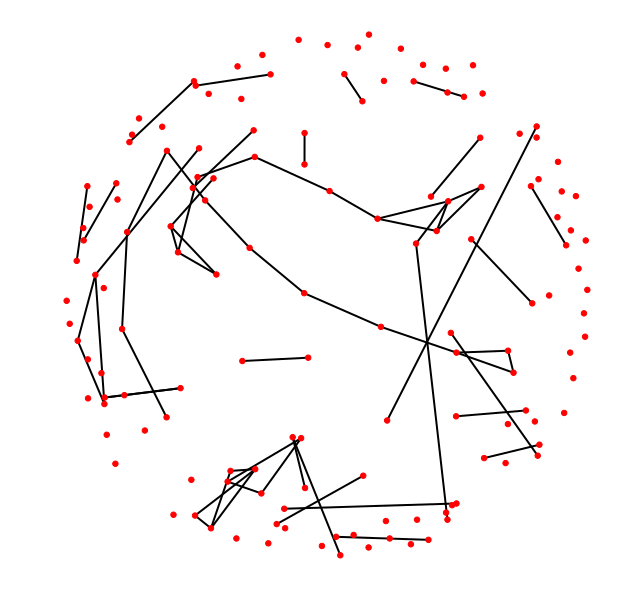

In [141]:
G2 = G.subgraph(nodeSet)
plt.figure(figsize=(8,8))
nx.draw(G2,pos=pos,node_shape='o',node_size=30,width=2)

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


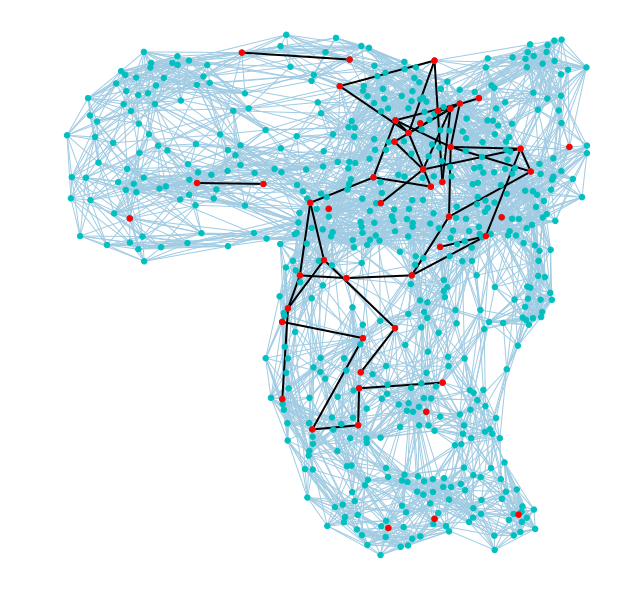

In [88]:
plt.figure(figsize=(8,8))
nx.draw(G,node_shape='o',pos=pos,node_size=30,pos=pos, node_color='c' ,edge_color='#A0CBE2')
nx.draw(G2,node_shape='o',pos=pos, node_size=30,width=2)
# nx.drawing.nx_pylab.draw_networkx_nodes(G,pos,nodeSet,node_size=50)
# nx.drawing.nx_pylab.draw_networkx_edges(G,pos,votes.keys(),width=1.5,edge_color='y')

**使用图布局算法(Fruchterman-Reingold force-directed algorithm)**

事实上默认就是用了图布局算法的

In [ ]:
plt.figure(figsize=(8,8))
nx.draw(G2,node_shape='o',node_size=30,width=2)

## 对提取的结点绘制knn图

In [144]:
subData = data.iloc[list(nodeSet),:]
print("length of subData :",len(subData))
subData.head()

length of subData : 169


,0,1,2
2,0.538826,0.464909,0.494495
3,0.562822,0.497936,0.503670
518,0.465099,0.727854,0.789908
8,0.461174,0.464909,0.503670
520,0.478430,0.746203,0.789908


**设定k**

In [145]:
k = 6

In [146]:
# a = preprocessing.normalize(data.values)
b = subData.values

In [147]:
neigh = NearestNeighbors(n_neighbors=k+1) # 因为之后提取最近点时会包括点自身
neigh.fit(b)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=7, p=2, radius=1.0)

In [148]:
disMat,nodeMat = neigh.kneighbors(b)

In [149]:
G3 = nx.Graph()

In [150]:
edges = []
for i,(neighbors,distances) in enumerate(zip(nodeMat,disMat)):
    edges +=[(i, neighbors[j], distances[j]) for j in range(k+1) if neighbors[j]!=i]
print(edges[:5])

[(0, 7, 0.009174999999999989), (0, 77, 0.020666609905835954), (0, 1, 0.04184221994588718), (0, 136, 0.04211611483743484), (0, 146, 0.04923465475658379)]


In [151]:
G3.add_weighted_edges_from(edges)

<IPython.core.display.Javascript object>


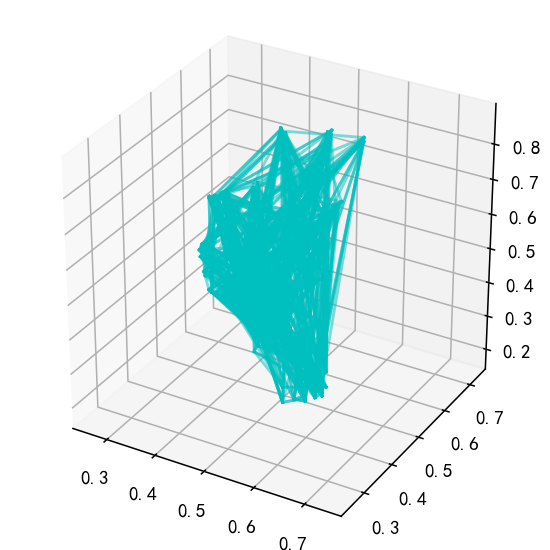

(0.4273395, 0.5726605, 0.23011960000000004, 0.7510444)

In [159]:
fig = plt.figure(figsize=(4,4))
ax = Axes3D(fig)
# ax.scatter3D(*data.to_numpy().T,marker='.')
for a,b,_ in edges:
    if np.random.rand()>0.:
        ax.plot(*data.iloc[[a,b]].to_numpy().T,alpha=0.5,color='c')
ax.axis('equal')

<IPython.core.display.Javascript object>


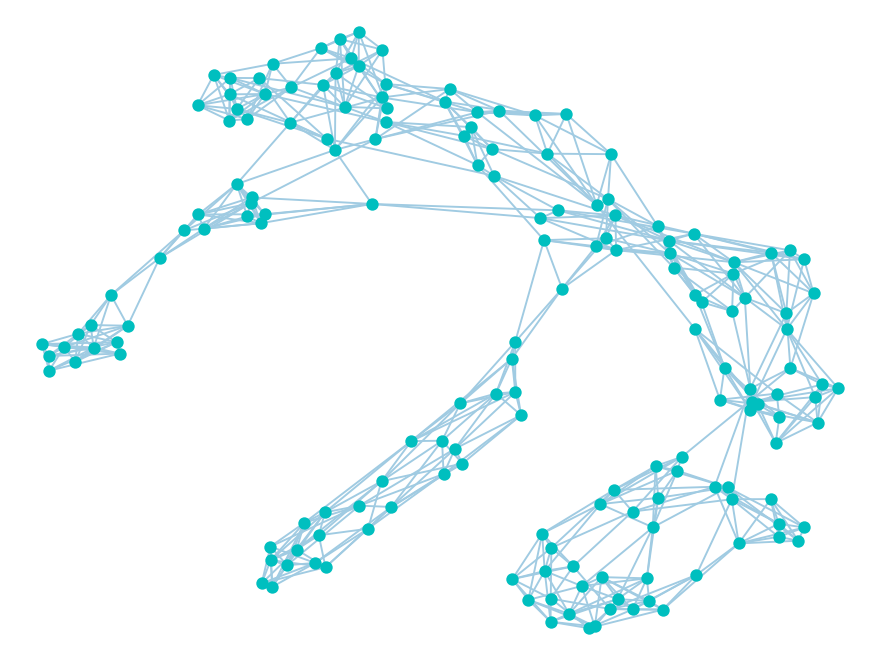

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [153]:
nx.draw(G3,node_shape='o',node_size=30,node_color='c',edge_color='#A0CBE2')